<a href="https://colab.research.google.com/github/Sugi1999/Computational-Biology-Projects/blob/main/Modeling_Intracellular_Calcium_Oscillations_and_Performing_3_way_Design_of_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOE 437 MIDTERM: DESIGN OF EXPERIMENTS

**Please copy this notebook to your student folder and put your answers in that notebook.**

# Introduction

BioModels model 45 shows bursting behavior of Calcium oscillations using the chemical species ``EC``, ``X``, ``Y``, and ``Z``.
Factors affecting the Ca oscillations include the initial concentrations of these four chemical species.

Performing a computational study to find levels of these factors such that:
1. ``Y`` has oscillations of at least 1.5 Hz during the times 5 sec to 30 sec.
1. The "amplitude" (Fourier coefficient) for the oscillations is at least 2.5.
1. All concentrations of the chemical species are non-negative in the simulation.

To answer this question I will perform a Design of Experiments, and create an experimental infrastructure.

1. Experimental Infrastructure

   1. ``runExperiment`` runs an experiment for levels of initial values of chemical species and returns
   the result of the simulation. The function 
   plots the results. 
   1. ``getResponse`` calculates the the
   values of the frequency with the largest amplitude (along with the amplitude) for a chemical species over a
   designated time interval.
   1. ``runStudy`` runs a set of experiments, checking for combinations of factor levels that match the
   objectives of this study. Shows the results of my search for levels of factors and that the levels
   I select satisfy the conditions of the problem by doing a plot.
    
1. I conduct an extra set of studies and performed a 3 way design of experiments on factors EC, X, Y and Z. 

# Preliminaries
This section provides the setup to run my python codes.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
import itertools
import seaborn as sns

import matplotlib.gridspec as gridspec
from scipy import fftpack
import tellurium as te

## Model

In [ ]:
ROADRUNNER = te.loadSBMLModel(
    "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
print(ROADRUNNER.getAntimony())

// Created by libAntimony v2.12.0
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

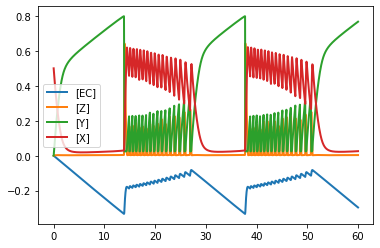

In [ ]:
ROADRUNNER.plot(ROADRUNNER.simulate(0,60, 1200))

## Constants

In [ ]:
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value
TIME_OFFSET = 150

# Simulation constants
START_TIME = 0  # Start time for the simulation
END_TIME = 60  # End time for the simulation
BURST_DCT = {0: (15, 25), 1: (40, 50)}  # Where bursts should be preserved
NUM_POINT = 10*(END_TIME - START_TIME)  # Number of points in output
PARAMETERS = ["X", "Y", "Z", "EC"]
TIME = "time"

## Helpers

In [ ]:
def arrToDF(arr, isSimulation=True):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    if isSimulation:
        df = df.set_index(TIME)
    return df

# Tests
arr = ROADRUNNER.simulate()
df = arrToDF(arr)
assert(len(df) > 0)
assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


In [ ]:
def runSimulation(parameterDct=None, roadrunner=ROADRUNNER,numPoint=NUM_POINT):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float - value for parameter
    roadrunner: ExtendedRoadRunner
    startTime: float
    endTime: float
    numPoint: int
       
    Returns
    -------
    DataFrame results of simulation
    """
    if parameterDct is None:
        parameterDct = {}
    roadrunner.resetAll()
    for parameter, value in parameterDct.items():
        roadrunner[parameter] = value
    data = roadrunner.simulate(START_TIME, END_TIME, numPoint)
    return arrToDF(data)

# Tests
df1 = runSimulation()
df2 = runSimulation(parameterDct={"Y": 100})
assert(isinstance(df1, pd.DataFrame))
assert(not df1.equals(df2))
print("OK!")

OK!


In [ ]:
def plotOverTime(df, title="", figsize=(8, 4)):
    """
    Plots a simulation dataframe

    Parameters
    ----------
    df: DataFrame (SimulationOutput format)
    title: str
    figsize: (float, float)
        size of figure
        
    Returns
    -------
    matplotlib.Axes
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    arr = df.values
    p = ax.plot(df.index, arr)
    _ = ax.legend(p, df.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
    return ax

# Tests
import matplotlib
df = runSimulation()
ax = plotOverTime(df)
if True:
    plt.close()  # Don't show the plot
assert("AxesSubplot" in str(type(ax)))
print("OK!")

OK!


In [ ]:
def calcFFT(molecule, df):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
        
    Returns
    -------
    list-float, list-float
        freqs, amplitudes
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = molecule
    values = df[col].values
    numPoint = len(df)
    endTime = max(df.index)
    startTime= min(df.index)
    span = (endTime - startTime)/numPoint
    freqs = fftpack.fftfreq(numPoint, span)
    fftValues = np.abs(fftpack.fft(values))
    # Eliminate frequency of 0
    return freqs[1:], fftValues[1:]

# Tests
TEST_DF = runSimulation()
sel = [(i >=15) and (i < 28) for i in df.index]
freqs, ampls = calcFFT("Y", TEST_DF[sel])
idx = [i for i in range(len(freqs)) if ampls[i] == max(ampls)][0]
TEST_PEAK_FREQUENCY = freqs[idx]
assert(TEST_PEAK_FREQUENCY > 1)
print("OK!")

OK!


In [ ]:
def calcFFTPeak(molecule, df, selFunc=None):
    """
    Obtains the highest amplitude frequency and value for the molecule.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
    selFunc: Function
       boolean function of time
    
    Returns
    -------
    float, float: frequency, amplitude
    """
    if selFunc is None:
        selFunc = lambda v: True
    sel = [selFunc(i) for i in df.index]
    newDF = df.copy()  # Don't destroy the original dataframe
    newDF = newDF[sel]
    frequencies, amplitudes = calcFFT(molecule, newDF)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(frequencies)),
          key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return frequencies[topIdx], amplitudes[topIdx]

# Tests
selFunc = lambda t: (t > 15) and (t < 28)
freq, ampl = calcFFTPeak("Y", TEST_DF, selFunc=selFunc)
assert(np.isclose(freq, TEST_PEAK_FREQUENCY))
print("OK!")

OK!


In [ ]:
def runFFTExperiment(parameterDct=None, selFunc=None):
    """
    Runs an experiment by changing parameters by the specified
    fractions and calculating FFT peak frequencies and amplitudes.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: percent change the parameter
       
    Returns
    -------
    frequencySer: pd.Series
        index: molecule
        value: frequency with largest amplitude
    amplitudeSer: pd.Series
        index: molecule
        value: largest amplitude
    """
    if parameterDct is None:
        parameterDct = {}
    df = runSimulation(parameterDct=parameterDct)
    #----------------------------------------
    if selFunc is None:
        selFunc = lambda v: True
    #-----------------------------------------------
    sel = [selFunc(i) for i in df.index]
    frequencyDct = {}
    amplitudeDct = {}
    for molecule in df.columns:
        frequency, amplitude = calcFFTPeak(molecule, df, selFunc=selFunc)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return pd.Series(frequencyDct), pd.Series(amplitudeDct)

# Tests
percent = 100
parameterDct = {"Y": 0.1, "EC": 0}
selFunc = lambda t: (t >=15) and (t < 28)
baseFreqSer, baseAmplSer = runFFTExperiment(parameterDct=None, selFunc=selFunc)
freqSer, _ = runFFTExperiment(parameterDct=parameterDct, selFunc=selFunc)
for ser in [baseFreqSer, freqSer, baseAmplSer]:
    assert(isinstance(ser, pd.Series))
assert(not baseFreqSer.equals(freqSer))
print("OK!")

OK!


# Results

##1 First DOE from Preliminary Exploration

a) My base line is 0.2 for EC, X, and Z. My baseline is 0.8 for Y.

b) the factors are the inital concentrations of the chemical species EC, X, Y and Z. 

c) The levels of the factors are -100%, -50%, 0%(baseline), +50%, +100% for EC, X, Z. And 

d) I choose a 4WD. This is because I wanted to model every possible interaction between EC, X, Y, and Z. I knew from preliminary testing with a 1WD that I only saw EC species > 0 at high values of Y. So I used that to inform my level design, and choose a fewer number of levels to model more interactions in a timely manner. 4 factors, 5 levels, with a 4WD will require 625 experiments (as calculated with my nWD calculator). 


## Results of DOE

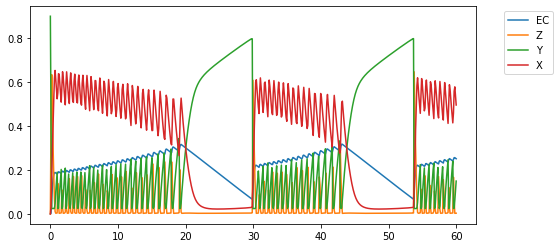

0.0

In [ ]:
#Preliminary Testing 
selFunc = lambda t: (t >=5) and (t < 30)
runSimulation(parameterDct={"X":10})
df = runSimulation(parameterDct={"EC":0, "X":0, "Y":0.9, "Z":0})
plotOverTime(df)
plt.show()
df
#freqs, amplitudes = calcFFT("Y", df)
#print(freqs[22])
#calcFFTPeak("Y", df, selFunc)
#runFFTExperiment(parameterDct={"X":0.1, "Y":0.1})
min(df['EC'])

#have identified that EC species > 0 only with high y values

In [ ]:
def runExperiment(parameterDct):
  '''
  runs an experiment for levels of initial values of chemical species and 
  returns  the result of the simulation. The function optionally  plots the
  results.

  Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: levels of the parameter
       
    Returns
    -------
    df: dataframe
      data frame with time index and species concentrations as columns
  '''
  df = runSimulation(parameterDct)
  return df

assert(runExperiment({"X":0.1, "Y":0.9, "EC":0.1, "Z":0.1}).loc[0,'X']==0.1)
assert(runExperiment({"X":0.1, "Y":0.9, "EC":0.1, "Z":0.1}).loc[0,'Y']==0.9)
assert(runExperiment({"X":0.1, "Y":0.9, "EC":0.1, "Z":0.1}).loc[0,'EC']==0.1)
assert(runExperiment({"X":0.1, "Y":0.9, "EC":0.1, "Z":0.1}).loc[0,'Z']==0.1)

In [ ]:
def getResponse(species, df, selFunc=None):
  '''
  calculates the the values of the frequency with the largest amplitude 
  (along with the amplitude) for a chemicalspecies over a designated time
  interval.

  Parameters
    ----------
    molecule: str
    df: DataFrame
    selFunc: Function
       boolean function of time
    
  Returns
  -------
  float, float: frequency, amplitude
  '''
  return calcFFTPeak(species, df, selFunc)

df = runExperiment({"X":0.1, "Y":0.9, "EC":0.1, "Z":0.1})
selFunc = lambda t: (t >=15) and (t < 28)
assert(type(getResponse("X", df, selFunc=selFunc))==tuple)
assert(type(getResponse("X", df, selFunc=selFunc)[0])==np.float64)
assert(type(getResponse("X", df, selFunc=selFunc)[1])==np.float64)

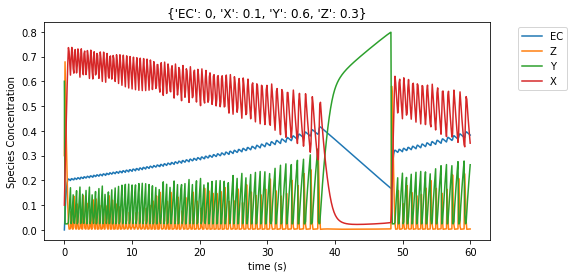

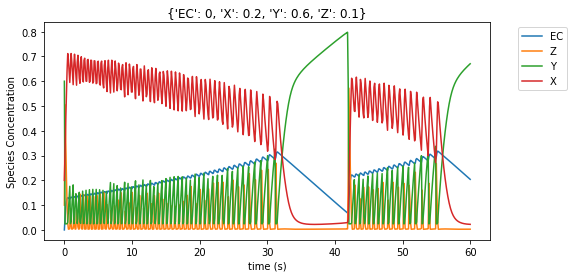

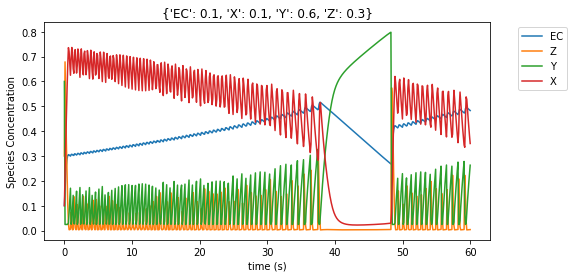

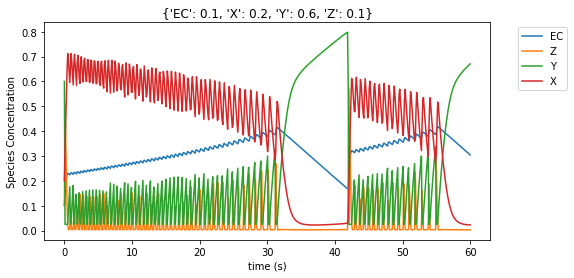

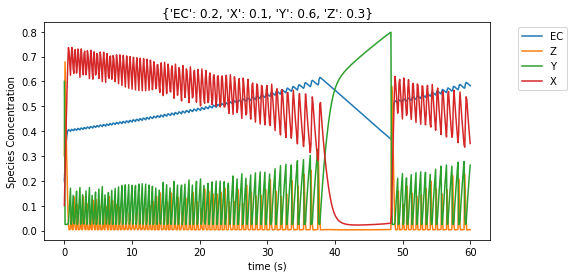

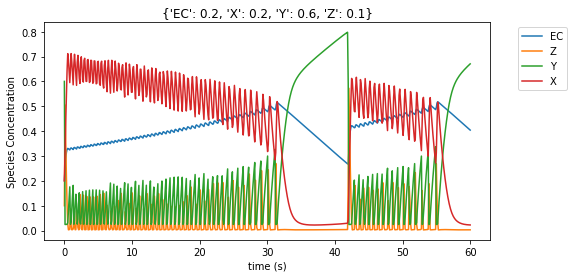

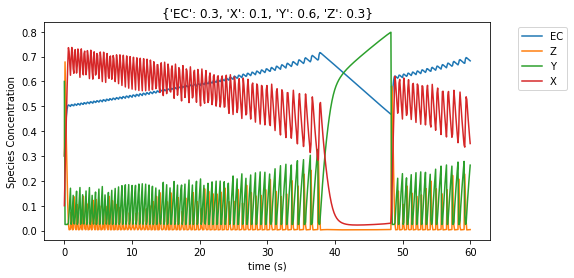

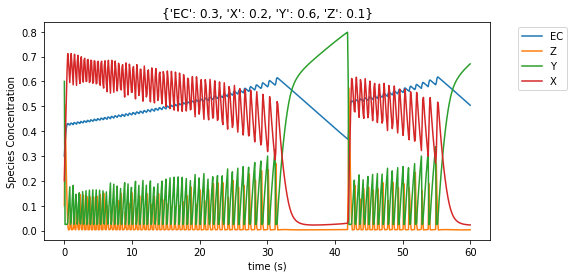

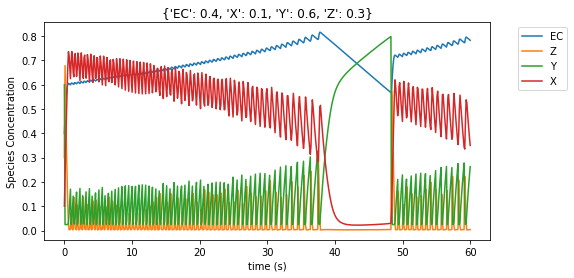

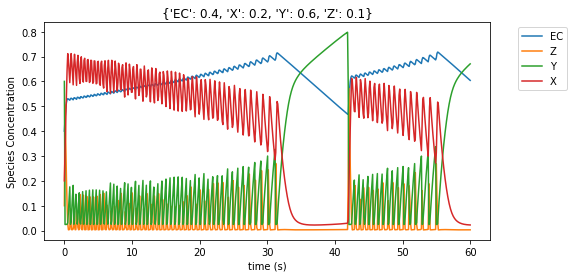

,EC,X,Y,Z,Y Freq w/ Largest Amp,Amp,All Species > 0
0,0.0,0.1,0.6,0.3,2.004685,3.213564,True
1,0.0,0.2,0.6,0.1,1.884404,2.710794,True
2,0.1,0.1,0.6,0.3,2.004685,3.213548,True
3,0.1,0.2,0.6,0.1,1.884404,2.712025,True
4,0.2,0.1,0.6,0.3,2.004685,3.213712,True
5,0.2,0.2,0.6,0.1,1.884404,2.710340,True
6,0.3,0.1,0.6,0.3,2.004685,3.213515,True
7,0.3,0.2,0.6,0.1,1.884404,2.709541,True
8,0.4,0.1,0.6,0.3,2.004685,3.213258,True
9,0.4,0.2,0.6,0.1,1.884404,2.711580,True


In [ ]:
import itertools
def runStudy(EC_levels, X_levels, Y_levels, Z_levels, selFunc):
  '''
  runs a set of experiments, checking for combinations of factor levels 
  that match the objectives of this study. Shows the results of search 
  for levels of factors. Shows that levels selected satisfy the conditions
  by plotting.

  Parameters
    ----------
    EC_levels: list of float values, initial starting values for a species
               that we would like to test. 
               *same for X_levels, Y_levels, Z_levels
    selFunc: Function
       boolean function of time we would like to simulate over
    
  Returns
  -------
  satsifactory: a tuple of (parameterDict, df)
                -parameterDict
                dictionary of key: value, species: inital concentration
                -df
                dataframe of simulation run that meets requirements
  stat_df: a summary df of each satsifactory df's key qualities
  '''
  #4WD
  a = [EC_levels, X_levels, Y_levels, Z_levels]
  #all possible permutations
  factor_levels = list(itertools.product(*a))

  #setting up lists to keep track of intial species conc.
  ECs=[]
  Xs=[]
  Ys=[]
  Zs=[]
  #keeping track of yfreq, amp, all species
  yfreq=[]
  Amp=[]
  AllSpecies=[]
  satisfactory = []

  #make parameterDict
  for n in range(len(factor_levels)):
    parameterDict = {"EC":factor_levels[n][0], "X":factor_levels[n][1],
                 "Y":factor_levels[n][2], "Z":factor_levels[n][3]}
    #run the experiment
    df = runExperiment(parameterDct=parameterDict)

    #see if they pass requirements
    frequency, amplitude = getResponse("Y", df, selFunc=selFunc)
    if (frequency >= 1.5) and (amplitude >= 2.5):
      if min(df['EC']>=0) and min(df['X']>0) and min(df['Y']>0) and min(df['Z']>0):
        satisfactory.append([parameterDict, df])
        #appending succesfull intial species values
        ECs.append(parameterDict['EC'])
        Xs.append(parameterDict['X'])
        Ys.append(parameterDict['Y'])
        Zs.append(parameterDict['Z'])
        #appending requirements when they pass
        yfreq.append(frequency)
        Amp.append(amplitude)
        AllSpecies.append(True)

  #plot succesful simulations
  for pair in satisfactory:
    plotOverTime(pair[1])
    plt.title(pair[0])
    plt.xlabel('time (s)')
    plt.ylabel('Species Concentration')
    plt.show()

  stat_df = pd.DataFrame({'EC':ECs, "X":Xs, "Y":Ys, "Z":Zs, "Y Freq w/ Largest Amp": yfreq, "Amp":Amp, "All Species > 0":AllSpecies})
  return satisfactory, stat_df



EC_levels = [0, 0.1, 0.2, 0.3, 0.4]
X_levels = [0, 0.1, 0.2, 0.3, 0.4]
Y_levels = [0.6, 0.7, 0.8, 0.9, 1]
Z_levels = [0, 0.1, 0.2, 0.3, 0.4]
selFunc = lambda t: (t >=5) and (t < 30)
satisfactory, stat_df = runStudy(EC_levels, X_levels, Y_levels, Z_levels, selFunc)
display(stat_df)

#my species should never dip below 0
assert(stat_df['All Species > 0'].all()==True)
#y should have a frequency of at least 1.5, if the freq with larges amp is 1.5
#y does have a frequency of at leat 1.5
assert(min(stat_df['Y Freq w/ Largest Amp'])>=1.5)
#this frequency should have an amp of at least 2.5
assert(min(stat_df['Amp'])>=2.5)
#all of my initial values should be greater than 0
assert(stat_df['EC'].all()>=0)
assert(stat_df['X'].all()>=0)
assert(stat_df['Y'].all()>=0)
assert(stat_df['Z'].all()>=0)

In [ ]:
import operator as op
from functools import reduce

def ncr(n, r):
  '''
  calculates the total number of possible combinations
  Parameters
  ----------
  K - number of factors
  n - n way design

  Returns
  -------
  total number of possible combinations
  '''
  r = min(r, n-r)
  numer = reduce(op.mul, range(n, n-r, -1), 1)
  denom = reduce(op.mul, range(1, r+1), 1)
  return numer // denom

def nWD_calc(num_factors, num_levels, WD_level):
  '''
  calcualtes the total number of experiments needed for a DOE

  Paramters
  ---------
  num_factors - number of factors
  num_levels - number of levels for each factor
  WD_level - n way design

  Returns
  -------
  count - float, total number of experiments needed to run DOE
  '''
  count = 1 #accounting for 0WD is 1 exp
  while WD_level > 0:
    count += ncr(num_factors, WD_level) * ((num_levels - 1) ** WD_level)
    WD_level -= 1
  return(count)

#for 1WD
exp_num_1WD = nWD_calc(16, 7, 1)
print(exp_num_1WD, 'experiments for a 1WD')

#for 1WD
exp_num_1WD = nWD_calc(16, 7, 2)
print(exp_num_1WD, 'experiments for a 2WD')

#for 1WD
exp_num_1WD = nWD_calc(16, 7, 10)
print(exp_num_1WD, 'experiments for a 10WD')

# test
assert(nWD_calc(2,3,1)==5)
assert(nWD_calc(2,3,0)==1)
# how I found how many experiments I need to run for my 4WD
nWD_calc(4, 5, 4)

97 experiments for a 1WD
4417 experiments for a 2WD
624731176321 experiments for a 10WD


625

## Results of 3WD 

In my preliminary testing code block, I played around with various inital starting values for my EC, X, Y, and Z, species. I found that EC dipped below 0 in most cases except for when Y had an initial starting value around 0.5. I also found that I lost oscillitaory responses if some of the values initialized at 1 or above. With this information, I set up my levels to be between 0->0.5 for my parameters EC, X, and Z. And levels to be between 0.5->1 for Y. 


I then computed with my WD calculator how many experiments I would have to conduct with a 4WD for 4 parameters at 5 levels. I found I would need to conduct 625 experiments, which I thought was reasonable. 


I used itertools to generate all possible permutations of my parameters and their levels, then ran an experiment for each combination. I checked for our requirements, 1) Y has oscillations of at least 1.5Hz, by looking for the peak frequency, 2) The amplitude for those oscillations is at least 2.5, but looking at the amp of that peak frequency, 3) All concentrations of the chemical species are non-negative, by finding the minimum of each species simulation to be greater than 0. Only simulations that passed all 3 requirements were passed in to my return list of data frames and parameter dictionaries. 


Finally, I plotted every simulation that passed, and printed an additonal data frame that kept track of parameter values, and our conditions, to make it easier to read. 